# Introduction

This notebook analyses a loan dataset taken from a GitHub user ([prasertcbs](https://github.com/prasertcbs/basic-dataset)). There wasn't any extra information alongside it (e.g. we have the loan amount but not the currency or frequency, and we don't know where the data itself was taken from) but I noticed that (a) the columns were all self-explanatory and (b) there were relatively few rows (only 614), and I was wondering if it would be possible to train a model to predict whether a given loan would be approved with such a small sample. 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Set2")

df = pd.read_csv('Loan-Approval-Prediction.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [46]:
df.shape

(614, 13)

In [27]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [88]:
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Most of the features are categorical and there are missing values in some of the columns. For most of these the nulls make up at most about 5% of the values so we should be okay to impute these. For the credit history, however, this rises to 8% so we will have to take a further look at this. 

In [29]:
df.isna().mean()

Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

A brief look over the head of the dataframe also gives rise to the following observations.
- The dependents column is given as an integer but encoded as a string.
- The coapplicant income, loan amount and loan term columns are encoded as floats but look as though they should be integers.
- The credit history column is given as a float but looks as though it should be a binary. 

Given that the dataset is small, we'll take a quick look at each feature in turn to make sure we know what we're dealing with before modelling. Beforehand, even though it will be made binary for modelling, we'll change the credit history dtype to object so that it is treated in the same way as for the other categorical features.

In [73]:
df['Credit_History'] = df['Credit_History'].astype('object')

In [75]:
categorical = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 
               'Property_Area']

numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

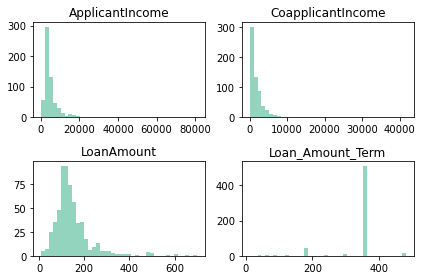

In [91]:
#Inspect numerical columns
df[numerical].hist(grid=False, bins=40, alpha=0.7)

plt.tight_layout();

In [44]:
df[numerical].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


- `ApplicantIncome`, `CoapplicantIncome` and `LoanAmount` are all right-skewed.
- The majority of loan-applicant incomes are below 6000 but there are a few outliers and at least one at 81000.
- Most coapplicant incomes are below 2000 and 25% of coapplicants have zero income.
- The median loan amount is 128 and 75% of loans are less than 170, though these go as high as 700. 
- The vast majority of the loans are at a fixed-term of 360 (days, presumably). We note that these are discrete values and so should be treated categorically for imputation. 

Now we'll check that the string entries in the categorical columns look okay and plot each feature as a countplot.

In [93]:
#Check that there aren't any typos in the cat entries
for cat in categorical:
    print(df[cat].value_counts(), '\n')

Male      489
Female    112
Name: Gender, dtype: int64 

Yes    398
No     213
Name: Married, dtype: int64 

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64 

Graduate        480
Not Graduate    134
Name: Education, dtype: int64 

No     500
Yes     82
Name: Self_Employed, dtype: int64 

1.0    475
0.0     89
Name: Credit_History, dtype: int64 

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64 



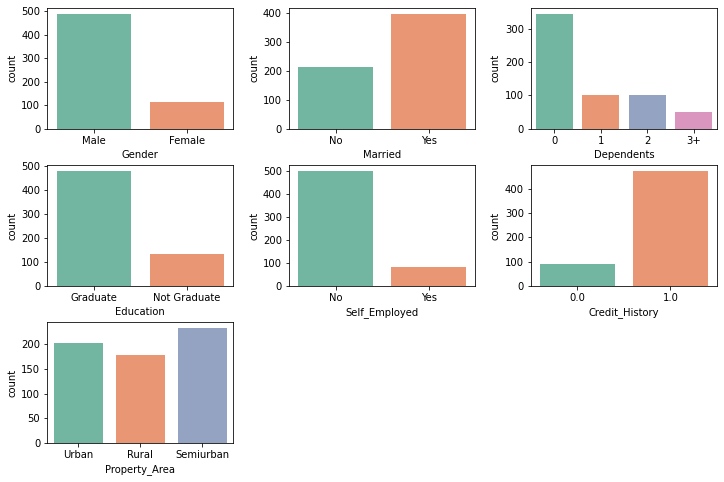

In [92]:
#Inspect categorical columns
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i, cat in enumerate(categorical):
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(x=cat, data=df, ax=ax)

In [77]:
df[categorical].describe(include='object')

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
count,601,611,599,614,582,564.0,614
unique,2,2,4,2,2,2.0,3
top,Male,Yes,0,Graduate,No,1.0,Semiurban
freq,489,398,345,480,500,475.0,233


- Most of the applicants (489 out of 601 that we have information for) are male and are labelled as graduates (480 of 614), though it should be noted that we do not have any information on whether this is from high school, college or university.
- Credit history has been obtained for most applicants (475 of 564) and most are not self-employed.
- About twice as many applicants are married as are not and the majority, more than half, have no dependents, with the rest of the population made having 1, 2 or 3+.

We finally examine our target variable, `Loan_Status`, which is the result of the application.

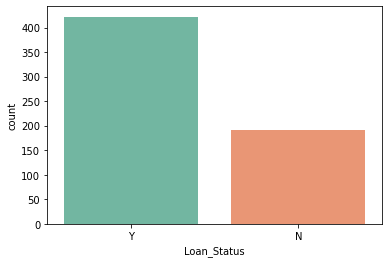

In [84]:
sns.countplot(x='Loan_Status', data=df);

There are about twice as many loans that are approved as not, so we have an imbalanced dataset, though not severely so. If our model seems to be struggling to predict the minority class later on, we will try and address this either through oversampling and by giving some thought to our choice of performance metric.

At this point a further step in the analysis would be to plot each of the features against the loan status to see if we could discern any interesting relationships or trends that might highlight factors that might be informative as to the outcome of the application, but for the moment we'll just proceed to preprocessing ahead of modelling. 